In [1]:
import tdmclient.notebook
await tdmclient.notebook.start()

In [7]:

import cv2
import math

import numpy as np
import matplotlib.pyplot as plt
from numpy.core.fromnumeric import size
from matplotlib import colors
#from asgiref.sync import sync_to_async #in order to load variables to communicate between sync and async



In [8]:
import optimal_path as op

from robot import Robot
from Map import Map
#from Local_navigation import* 
#from Mouvement import*
from vision import* 
from optimal_path import* 



map_lenght = 1
nb_of_square_by_side = 50
current = 1

In [9]:
global move 
move = False #bool which indicate how our robot is moving (1: avoid an object VS 0: following the optimal path)
kalman_bool = False
#pourcentage_reduc = 1


George = Robot()
Lausanne = Map(map_lenght, nb_of_square_by_side)

#VideoCap = vision_initialization()
VideoCap=cv2.VideoCapture(1)


In [11]:
#############################
#Test MASK
#############################

while True:
    ret, frame = VideoCap.read()
    mask = mask_map_init(frame)
    
    keyVal = cv2.waitKey(1) & 0xFF
    if keyVal == ord('q'):
        break
    cv2.imshow("mask",mask)


taille frame (1080, 1920, 3)
 la position goal
[array([1313,  658]), array([1313,  468])]
robot detected
if
Waiting robot position
goal (60, 19)
start position (9, 17)
Resized Dimensions :  (88, 50)
PATH COMPUTATION
1419
[[ 9 10 11 12 13 14 15 16 17 18 19 10 11 12 13 14 15 16 17 18 19 10 11 12
  13 14 15 16 17 18 19 11 12 13 14 15 16 17 18 19 20 11 12 13 14 15  9 16
  17 18 19  9 12 13 14 15 16 17 18 19 20 10 12 13 14 15 16 17 18 19 10 13
  14 15 16 17 18 19 20 11  9 13  8 14 15 16 17 11 18 19  9 14 15 16 17 18
  19 20 12  8 10  8 14 15 12 16 17 18 15 10 19 16 17 18 19 20 13 11  9 13
  16 17 15 11 18 19 16 20 17 18  9 14 19 12  8 10  8 17 18 12 19 20 14 15
  10 16 13 17 18 19 11  7  9 16 18 19 11 13 20 14  9 15 12  7  8 17 18  7
  10 19 20 21 22 23  8 24 25 26 27  7 28 17 15 29 10 12 19 13 20 30 14  7
  31 11 16 32  9 33 18 34 19 20 35 21 22 36 23 24 37 25 37  8 16 14 26 11
   9 38 18 38 12 13 27 38 20 28 39 10 39 15 39 29 40 40 30 40 39 17 31 40
  41 41  8 41 41 32  7 42 40 42 19 42 3

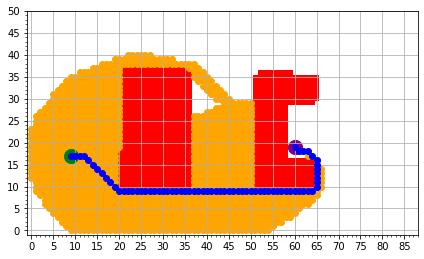

In [12]:

####################################
## INIT
####################################

# Prend une première image
ret, frame = VideoCap.read()
print("taille frame", frame.shape)

# Set the pourcentage value between the nb of pixel and nb of square by side
Lausanne.set_map_lenght(frame)
#print("Pourcentage",Lausanne.get_pourcentage())
# Set the robot goal, position and angle
goal = init_goal(frame, Lausanne.get_pourcentage())
#goal = (50, 40)
pos_robot = George.get_pos()
#print("GOAL", goal)



        
while (pos_robot[0] < 0) & (pos_robot[1] < 0):
    #ret, frame=VideoCap.read()
    #display(frame,1,0,0)
    ret, frame=VideoCap.read()
    #display(frame,1,0,0)
    pos_robot, angle = update(frame, Lausanne.get_pourcentage())  # fonction qui retourne la position angle etc....
    print("Waiting robot position") 
    

George.set_angle(angle)
George.set_goal(goal)
George.set_start_pos(pos_robot)
George.set_pos(pos_robot)
print ("goal", goal)
print ("start position", pos_robot)

# SET MAP
Lausanne.set_map_lenght(frame)
#print("Lausanna lenght", Lausanne.get_lenght())

# MASK 
mask = mask_map_init(frame)
#cv2.imshow("mask", mask)
cv2.imwrite("masque1.jpg", mask)

# Fin de l'init
Lausanne.init_grid(mask)
grille = Lausanne.get_map()
#cv2.imshow("grid", grille)
cv2.imwrite("grille.jpg", grille)

# OPTIMAL PATH
print("PATH COMPUTATION")
path, visitedNodes = op.path_computation(George.get_start() , George.get_goal() , Lausanne.get_lenght(), grille)

George.set_path(path) 
George.set_visit_nodes(visitedNodes) 

# Display the optimal path
op.display_map(Lausanne.get_lenght(),  grille,  George.get_visit_nodes(), George.get_path(), George.get_start(), George.get_goal())

display (frame, 0, 1, 1, 1, path, Lausanne.get_pourcentage())
cv2.imwrite("TOTAL.jpg", frame)

vision_end(VideoCap)



In [18]:
vision_end(VideoCap)

In [4]:


####################################
## while
####################################


kalman_bool = False


print('while start')
while True:#(George.get_pos() != George.get_goal()):
    
    # Read the camera
    ret, frame=VideoCap.read()
    
    # Reupere la position et angle --> XAV
    #x_robot, y_robot,angle_robot = update(frame, Lausanne.get_pourcentage(), kalman_bool)
    pos_robot,angle_robot = update(frame, Lausanne.get_pourcentage())
    George.set_pos(pos_robot)
    George.set_angle(angle_robot)
    print ('position',pos_robot ,angle_robot)
    display(frame,1,1,1)
    
    
    # Quit when we press q
    keyVal = cv2.waitKey(1) & 0xFF
    if keyVal == ord('q'):
        break
     
    sleep(0.1)

print("The End")
    

Hello World
 la position goal
[array([108, 126]), array([415, 202]), array([338, 238]), array([390, 307]), array([367, 309])]
(-1, -1)
(-0.10416666666666667, -0.10416666666666667)
(-0.10416666666666667, -0.10416666666666667)
(-0.10416666666666667, -0.10416666666666667)
(-0.10416666666666667, -0.10416666666666667)
(-0.10416666666666667, -0.10416666666666667)
(-0.10416666666666667, -0.10416666666666667)
(-0.10416666666666667, -0.10416666666666667)
(-0.10416666666666667, -0.10416666666666667)
(-0.10416666666666667, -0.10416666666666667)
(-0.10416666666666667, -0.10416666666666667)
(-0.10416666666666667, -0.10416666666666667)
(-0.10416666666666667, -0.10416666666666667)
(-0.10416666666666667, -0.10416666666666667)
(-0.10416666666666667, -0.10416666666666667)
(-0.10416666666666667, -0.10416666666666667)
(-0.10416666666666667, -0.10416666666666667)
(-0.10416666666666667, -0.10416666666666667)
(-0.10416666666666667, -0.10416666666666667)
(-0.10416666666666667, -0.10416666666666667)
(-0.104166

robot detected
if
position (10.729166666666668, 12.5) 0.037020115873929914
robot detected
if
position (10.729166666666668, 12.5) 0.037020115873929914
robot detected
if
position (10.625, 12.604166666666668) 0.03771795246686341
robot detected
if
position (10.729166666666668, 12.604166666666668) 0.05654343694481696
robot detected
if
position (10.833333333333334, 12.5) 0.01817981507298161
robot detected
if
position (10.729166666666668, 12.604166666666668) 0.037020115873929914
robot detected
if
position (10.729166666666668, 12.5) 0.03771795246686341
robot detected
if
position (10.625, 12.604166666666668) 0.03844259002118792
robot detected
if
position (10.833333333333334, 12.395833333333334) 0.0
robot detected
if
position (10.9375, 12.395833333333334) 0.01817981507298161
robot detected
if
position (10.833333333333334, 12.5) 0.03634762101902216
robot detected
if
position (10.729166666666668, 12.604166666666668) 0.05654343694481696
robot detected
if
position (10.9375, 12.8125) 0.09232933473159

robot detected
if
position (10.625, 12.5) 0.03771795246686341
robot detected
if
position (10.729166666666668, 12.604166666666668) 0.05549850524571561
robot detected
if
position (10.9375, 12.5) 0.017855245139548243
robot detected
if
position (10.729166666666668, 12.5) 0.037020115873929914
robot detected
if
position (10.729166666666668, 12.604166666666668) 0.05549850524571561
robot detected
if
position (11.145833333333334, 12.8125) 0.08749534080239142
robot detected
if
position (10.833333333333334, 12.395833333333334) 0.01817981507298161
robot detected
if
position (10.625, 12.395833333333334) 0.0
robot detected
if
position (11.145833333333334, 12.604166666666668) 0.05167808448243011
robot detected
if
position (10.833333333333334, 12.395833333333334) 0.0185164020680077
robot detected
if
position (10.833333333333334, 12.395833333333334) 0.01817981507298161
robot detected
if
position (10.833333333333334, 12.5) 0.03634762101902216
robot detected
if
position (10.729166666666668, 12.5) 0.03702

position (11.041666666666668, 12.8125) 0.07006058263845612
position (11.041666666666668, 12.8125) 0.07006058263845612
position (11.041666666666668, 12.8125) 0.07006058263845612
position (11.041666666666668, 12.8125) 0.07006058263845612
position (11.041666666666668, 12.8125) 0.07006058263845612
position (11.041666666666668, 12.8125) 0.07006058263845612
position (11.041666666666668, 12.8125) 0.07006058263845612
position (11.041666666666668, 12.8125) 0.07006058263845612
position (11.041666666666668, 12.8125) 0.07006058263845612
position (11.041666666666668, 12.8125) 0.07006058263845612
position (11.041666666666668, 12.8125) 0.07006058263845612
position (11.041666666666668, 12.8125) 0.07006058263845612
position (11.041666666666668, 12.8125) 0.07006058263845612
position (11.041666666666668, 12.8125) 0.07006058263845612
position (11.041666666666668, 12.8125) 0.07006058263845612
position (11.041666666666668, 12.8125) 0.07006058263845612
position (11.041666666666668, 12.8125) 0.070060582638456

robot detected
if
position (48.54166666666667, 13.958333333333334) 0.13640260440094817
robot detected
if
position (48.54166666666667, 14.0625) 0.1618374312384233
position (48.54166666666667, 14.0625) 0.1618374312384233
robot detected
if
position (48.54166666666667, 13.854166666666668) 0.09966865249116186
position (48.54166666666667, 13.854166666666668) 0.09966865249116186
position (48.54166666666667, 13.854166666666668) 0.09966865249116186
position (48.54166666666667, 13.854166666666668) 0.09966865249116186
position (48.54166666666667, 13.854166666666668) 0.09966865249116186
robot detected
if
position (49.375, 13.645833333333334) 0.12184243701991787
robot detected
if
position (50.3125, 13.125) 0.03997868712329116
robot detected
if
position (50.41666666666667, 12.8125) 0.03997868712329116
position (50.41666666666667, 12.8125) 0.03997868712329116
robot detected
if
position (50.10416666666667, 11.354166666666668) -0.020830320036217324
robot detected
if
position (50.520833333333336, 11.875

robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24017100786017334
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2543680585532656
robot detected
if
position (23.020833333333336, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.770833333333334) -0.2310906671958972
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24017100786017334
robot detected
if
position (23.020833333333336, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.770833333333334) -0.2355449807208633
robot detected
if
position (23.020833333333336, 11.666666666666668) -0.24958692543698438
robot detected
if
position (23.020833333333336, 11.770833333333334) -0.2310906671958972
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2355449807208633
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2543680585532656
robot detected
if
position 

robot detected
if
position (23.020833333333336, 11.666666666666668) -0.24497866312686378
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2355449807208633
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.916666666666668, 11.5625) -0.26791042242333984
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (23.020833333333336, 11.666666666666668) -0.24497866312686378
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.770833333333334) -0.2310906671958972
robot detected
if
position (22.916666

robot detected
if
position (22.916666666666668, 11.770833333333334) -0.2355449807208633
robot detected
if
position (22.916666666666668, 11.5625) -0.26791042242333984
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24017100786017334
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2355449807208633
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2355449807208633
robot detected
if
position (23.020833333333336, 11.666666666666668) -0.24497866312686378
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (23.020833333333336, 11.666666666666668) -0.24497866312686378
robot detected
if
position (22.9166666

robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2355449807208633
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2355449807208633
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2355449807208633
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2310906671958972
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.770833333333334) -0.2355449807208633
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position 

robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.770833333333334) -0.2310906671958972
robot detected
if
position (22.916666666666668, 11.770833333333334) -0.2355449807208633
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.8125, 11.666666666666668) -0.2593317444006848
robot detected
if
position (22.8125, 11.770833333333334) -0.24017100786017334
robot detected
if
position (22.916666666666668, 11.770833333333334) -0.2310906671958972
robot detected
if
position (22.916666666666668, 11.770833333333334) -0.2355449807208633
robot detected
if
position (22.916666666666668, 11.770833333333334) -0.2355449807208633
robot detected
if
position (22.916666666666668, 11.

robot detected
if
position (22.8125, 11.666666666666668) -0.24017100786017334
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2355449807208633
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2355449807208633
robot detected
if
position (22.8125, 11.770833333333334) -0.24017100786017334
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2355449807208633
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2355449807208633
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.916666666666668, 11.666666666

robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.8125, 11.5625) -0.2593317444006848
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2310906671958972
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2310906671958972
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.916666666666668, 11.770833333333334) -0.2310906671958972
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2310906671958972
robot detected
if
position (22.916666666666668, 11.770833333333334) -0.2355449807208633
robot detected
if
position (22.916666666666668, 11.666666666666

robot detected
if
position (22.8125, 11.770833333333334) -0.2355449807208633
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2355449807208633
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2310906671958972
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2355449807208633
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.8125, 11.5625) -0.2782996590051114
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24017100786017334
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.8125, 11.770833333333334) -0.22082876972934828
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.770833333333334) -0.21

robot detected
if
position (22.8125, 11.770833333333334) -0.2355449807208633
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2355449807208633
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2355449807208633
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2355449807208633
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2355449807208633
robot detected
if
position (22.8125, 11

robot detected
if
position (22.8125, 11.770833333333334) -0.21655030497608926
robot detected
if
position (22.916666666666668, 11.770833333333334) -0.2310906671958972
robot detected
if
position (22.916666666666668, 11.770833333333334) -0.2355449807208633
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2355449807208633
robot detected
if
position (22.916666666666668, 11.770833333333334) -0.2310906671958972
robot detected
if
position (22.916666666666668, 11.770833333333334) -0.2124320205087419
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.916666666666668, 11.770833333333334) -0.21655030497608926
robot detected
if
position (22.91666666

robot detected
if
position (22.8125, 11.875) -0.21655030497608926
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2355449807208633
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.8125, 11.770833333333334) -0.2355449807208633
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2495869254369

robot detected
if
position (22.8125, 11.770833333333334) -0.2355449807208633
robot detected
if
position (22.916666666666668, 11.770833333333334) -0.2310906671958972
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.8125, 11.770833333333334) -0.22082876972934828
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2355449807208633
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.8125, 11.770833333333334) -0.24017100786017334
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.770833333

robot detected
if
position (22.916666666666668, 11.770833333333334) -0.21655030497608926
robot detected
if
position (22.8125, 11.770833333333334) -0.22082876972934828
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2355449807208633
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2310906671958972
robot detected
if
position (22.916666666666668, 11.770833333333334) -0.2310906671958972
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.8125, 11.666666666666668) -0.2593317444006848
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.916666666666668, 11.666666666

robot detected
if
position (22.708333333333336, 11.5625) -0.2782996590051114
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.8125, 11.770833333333334) -0.2355449807208633
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2355449807208633
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2355449807208633
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.77083333

robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.8125, 11.770833333333334) -0.2355449807208633
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.8125, 11.770833333333334) -0.2355449807208633
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.770833333333334) -0.2310906671958972
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.666666666666668) -0

robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2355449807208633
robot detected
if
position (22.8125, 11.666666666666668) -0.2593317444006848
robot detected
if
position (22.916666666666668, 11.770833333333334) -0.2310906671958972
robot detected
if
position (22.8125, 11.666666666666668) -0.2355449807208633
robot detected
if
position (22.916666666666668, 11.770833333333334) -0.2310906671958972
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.770833333333334) -0.2355449807208633
robot detected
if
position (22.8125, 11.666666666666668) -0.2401710

robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.770833333333334) -0.2310906671958972
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.770833333333334) -0.2310906671958972
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.770833333333334) -0.21655030497608926
robot detected
if
position (22.8125

robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.770833333333334) -0.2310906671958972
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.8125, 11.666666666666668) -0.2593317444006848
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2355449807208633
robot detected
if
position (22.916666666666668, 11.770833333333334) -0.2355449807208633
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532

robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.8125, 11.5625) -0.2730087030867108
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2593317444006848
robot detected
if
position (22.916666666666668, 11.770833333333334) -0.2355449807208633
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.770833333333334) -0.2310906671958972
robot detected
if
position (22.8125, 11.770833333333334) -0.2355449807208633
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.770833333333334) -0.2310906671958972
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24

robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.8125, 11.770833333333334) -0.2355449807208633
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.8125, 11.770833333333334) -0.22082876972934828
robot detected
if
position (22.8125, 11.770833333333334) -0.2355449807208633
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.916666666666668, 11.770833333333334) -0.2355449807208633
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2355449807208633
robot detected
if
position (22.8125, 11.770833333333334) -0.2355449807208633
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if

robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.770833333333334) -0.2310906671958972
robot detected
if
position (22.916666666666668, 11.770833333333334) -0.2355449807208633
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.916666666666668, 11.770833333333334) -0.2310906671958972
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.770833333333334) -0.2310906671958972
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.770833333333334) -0.21655030497608926
robot detected
if
position (22.8125, 11.770833333333334) -0.2

robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.770833333333334) -0.2310906671958972
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.770833333333334) -0.2310906671958972
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.8125, 11.666666666666668) -0.24017100786017334
robot detected
if
position (22.8125, 11.770833333333334) -0.2355449807208633
robot detected
if
position (22.916666666666668, 11.6666666

robot detected
if
position (22.916666666666668, 11.770833333333334) -0.2310906671958972
robot detected
if
position (22.8125, 11.666666666666668) -0.2593317444006848
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.8125, 11.666666666666668) -0.2355449807208633
robot detected
if
position (22.916666666666668, 11.770833333333334) -0.2310906671958972
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2

robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.8125, 11.770833333333334) -0.2355449807208633
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.8125, 11.770833333333334) -0.2355449807208633
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.916666666666668, 11.770833333333334) -0.2310906671958972
robot detected
if
position (22.8125, 11.666666666666668) -0.2593317444006848
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.916666666666668, 11.770833333333334) -0.2310906671958972
robot d

robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.8125, 11.770833333333334) -0.22082876972934828
robot detected
if
position (22.8125, 11.770833333333334) -0.22082876972934828
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.770833333333334) -0.2310906671958972
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
rob

robot detected
if
position (22.8125, 11.770833333333334) -0.2355449807208633
robot detected
if
position (22.916666666666668, 11.770833333333334) -0.2310906671958972
robot detected
if
position (22.916666666666668, 11.770833333333334) -0.2310906671958972
robot detected
if
position (22.916666666666668, 11.770833333333334) -0.2310906671958972
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.770833333333334) -0.2310906671958972
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.916666666666668, 11.770833333333334) -0.23

robot detected
if
position (22.916666666666668, 11.770833333333334) -0.2310906671958972
robot detected
if
position (22.8125, 11.666666666666668) -0.2593317444006848
robot detected
if
position (22.916666666666668, 11.770833333333334) -0.2310906671958972
robot detected
if
position (22.8125, 11.875) -0.21655030497608926
robot detected
if
position (23.020833333333336, 11.666666666666668) -0.24497866312686378
robot detected
if
position (22.916666666666668, 11.770833333333334) -0.2355449807208633
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.8125, 11.770833333333334) -0.24017100786017334
robot detected
if
position (22.916666666666668, 11.770833333333334) -0.2310906671958972
robot detected
if
position (22.8125, 11.770833333333334) -0.2355449807208633
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.8125, 11.666666666666668) -0.2593317444006848
robot 

robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.916666666666668, 11.770833333333334) -0.2310906671958972
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.770833333333334) -0.2310906671958972
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.770833333333334) -0.2310906671958972
robot detected
if
position (22.8125, 11.770833333333334) -0.2355449807208633
robot detected
if
position (22.8125, 11.770833333333334) -0.2355449807208633
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2495869254369

robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.8125, 11.770833333333334) -0.2355449807208633
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.916666666666668, 11.770833333333334) -0.2310906671958972
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.916666666666668, 11.770833333333334) -0.2310906671958972
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.8125, 11.770833333333334) -0.2355449807208633
robot detected
if


robot detected
if
position (22.916666666666668, 11.770833333333334) -0.2310906671958972
robot detected
if
position (22.8125, 11.770833333333334) -0.2355449807208633
robot detected
if
position (22.8125, 11.770833333333334) -0.2355449807208633
robot detected
if
position (22.916666666666668, 11.770833333333334) -0.2310906671958972
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.916666666666668, 11.770833333333334) -0.2310906671958972
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.8125, 11.770833333333334) -0.2355449807208633
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.916666666666668, 11.770833333333334) -0.2310906671958972
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.916666666666668, 11.770833333333334) -0.2310906671958972
robot detected
if
pos

robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.8125, 11.770833333333334) -0.2355449807208633
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.8125, 11.770833333333334) -0.24017100786017334
robot detected
if
position (22.8125, 11.666666666666668) -0.2644883825492325
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.770833333333334) -0.2310906671958972
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robo

robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.8125, 11.5625) -0.2730087030867108
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.770833333333334) -0.2310906671958972
robot detected
if
position (22.8125, 11.770833333333334) -0.2355449807208633
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
i

robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
i

robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.916666666666668, 11.770833333333334) -0.2310906671958972
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (2

robot detected
if
position (22.8125, 11.770833333333334) -0.2355449807208633
robot detected
if
position (22.8125, 11.5625) -0.2593317444006848
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.8125, 11.770833333333334) -0.2355449807208633
robot detected
if
position (22.8125, 11.770833333333334) -0.2355449807208633
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.708333333333336, 11.5625) -0.2782996590051114
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.916666666666668, 11.770833333333334) -0.2310906671958972
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.8125, 11.770833333333334) -0.2355

robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.8125, 11.666666666666668) -0.2593317444006848
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.8125, 11.770833333333334) -0.2355449807208633
robot detected
if
position (22.8125, 11.770833333333334) -0.2310906671958972
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.8125, 11.770833333333334) -0.2355449807208633
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.8125, 11.770833333333334) -0.24017100786017334
robot detected
if
position (22.916666666666668, 11.

robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.8125, 11.770833333333334) -0.2355449807208633
robot detected
if
position (22.8125, 11.5625) -0.2730087030867108
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.24958692543698438
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.8125, 11.666666666666668) -0.2543680585532656
robot detected
if
position (22.8125, 11.770833333333334) -0.235

robot detected
if
position (22.8125, 11.666666666666668) -0.24497866312686378
robot detected
if
position (22.8125, 11.666666666666668) -0.24497866312686378
robot detected
if
position (22.8125, 11.666666666666668) -0.2644883825492325
robot detected
if
position (22.8125, 11.666666666666668) -0.2499786214608224
robot detected
if
position (22.8125, 11.666666666666668) -0.24497866312686378
robot detected
if
position (22.8125, 11.666666666666668) -0.2499786214608224
robot detected
if
position (22.8125, 11.666666666666668) -0.24497866312686378
robot detected
if
position (22.8125, 11.666666666666668) -0.2644883825492325
robot detected
if
position (22.8125, 11.666666666666668) -0.2644883825492325
robot detected
if
position (22.8125, 11.666666666666668) -0.2644883825492325
robot detected
if
position (22.916666666666668, 11.666666666666668) -0.2593317444006848
robot detected
if
position (22.8125, 11.666666666666668) -0.2644883825492325
robot detected
if
position (22.8125, 11.770833333333334) -0.2

position (22.8125, 11.5625) -0.22082876972934828
robot detected
if
position (14.791666666666668, 20.625) 2.295294281914357
robot detected
if
position (14.6875, 20.104166666666668) 2.3311996965734245
position (14.6875, 20.104166666666668) 2.3311996965734245
position (14.6875, 20.104166666666668) 2.3311996965734245
position (14.6875, 20.104166666666668) 2.3311996965734245
position (14.6875, 20.104166666666668) 2.3311996965734245
position (14.6875, 20.104166666666668) 2.3311996965734245
position (14.6875, 20.104166666666668) 2.3311996965734245
robot detected
if
position (22.8125, 11.458333333333334) -0.3174587352546312
robot detected
if
position (22.8125, 11.5625) -0.24084645524141193
robot detected
if
position (22.8125, 11.5625) -0.31561566203876645
robot detected
if
position (22.8125, 11.5625) -0.34161549064780694
robot detected
if
position (22.916666666666668, 11.5625) -0.3152146997507109
robot detected
if
position (22.8125, 11.5625) -0.3016190462662398
robot detected
if
position (22.8

position (22.708333333333336, 11.458333333333334) -0.36120375549368183
position (22.708333333333336, 11.458333333333334) -0.36120375549368183
position (22.708333333333336, 11.458333333333334) -0.36120375549368183
position (22.708333333333336, 11.458333333333334) -0.36120375549368183
position (22.708333333333336, 11.458333333333334) -0.36120375549368183
position (22.708333333333336, 11.458333333333334) -0.36120375549368183
position (22.708333333333336, 11.458333333333334) -0.36120375549368183
position (22.708333333333336, 11.458333333333334) -0.36120375549368183
position (22.708333333333336, 11.458333333333334) -0.36120375549368183
position (22.708333333333336, 11.458333333333334) -0.36120375549368183
position (22.708333333333336, 11.458333333333334) -0.36120375549368183
position (22.708333333333336, 11.458333333333334) -0.36120375549368183
position (22.708333333333336, 11.458333333333334) -0.36120375549368183
position (22.708333333333336, 11.458333333333334) -0.36120375549368183
positi

robot detected
if
position (22.083333333333336, 11.25) -0.40489178628508365
robot detected
if
position (22.083333333333336, 11.25) -0.260602391747341
robot detected
if
position (22.083333333333336, 11.25) -0.416064505723823
robot detected
if
position (22.083333333333336, 11.25) -0.4353532751523023
robot detected
if
position (22.083333333333336, 11.25) -0.3964412832184414
position (22.083333333333336, 11.25) -0.3964412832184414
position (22.083333333333336, 11.25) -0.3964412832184414
position (22.083333333333336, 11.25) -0.3964412832184414
position (22.083333333333336, 11.25) -0.3964412832184414
position (22.083333333333336, 11.25) -0.3964412832184414
position (22.083333333333336, 11.25) -0.3964412832184414
position (22.083333333333336, 11.25) -0.3964412832184414
position (22.083333333333336, 11.25) -0.3964412832184414
position (22.083333333333336, 11.25) -0.3964412832184414
position (22.083333333333336, 11.25) -0.3964412832184414
position (22.083333333333336, 11.25) -0.3964412832184414

robot detected
if
position (22.604166666666668, 11.25) -0.3520443143154173
robot detected
if
position (22.604166666666668, 11.354166666666668) -0.3520443143154173
robot detected
if
position (22.604166666666668, 11.25) -0.3520443143154173
robot detected
if
position (22.604166666666668, 11.354166666666668) -0.3455555805817121
robot detected
if
position (22.604166666666668, 11.354166666666668) -0.3339450718448941
robot detected
if
position (22.604166666666668, 11.354166666666668) -0.3339450718448941
robot detected
if
position (22.604166666666668, 11.354166666666668) -0.3339450718448941
robot detected
if
position (22.604166666666668, 11.354166666666668) -0.31561566203876645
robot detected
if
position (22.604166666666668, 11.25) -0.3455555805817121
robot detected
if
position (22.604166666666668, 11.25) -0.3520443143154173
robot detected
if
position (22.604166666666668, 11.25) -0.3699060674565575
robot detected
if
position (22.604166666666668, 11.25) -0.3520443143154173
robot detected
if
pos

position (18.4375, 12.708333333333334) 2.804917834203066
position (18.4375, 12.708333333333334) 2.804917834203066
position (18.4375, 12.708333333333334) 2.804917834203066
position (18.4375, 12.708333333333334) 2.804917834203066
position (18.4375, 12.708333333333334) 2.804917834203066
position (18.4375, 12.708333333333334) 2.804917834203066
position (18.4375, 12.708333333333334) 2.804917834203066
position (18.4375, 12.708333333333334) 2.804917834203066
position (18.4375, 12.708333333333334) 2.804917834203066
position (18.4375, 12.708333333333334) 2.804917834203066
position (18.4375, 12.708333333333334) 2.804917834203066
position (18.4375, 12.708333333333334) 2.804917834203066
position (18.4375, 12.708333333333334) 2.804917834203066
position (18.4375, 12.708333333333334) 2.804917834203066
position (18.4375, 12.708333333333334) 2.804917834203066
position (18.4375, 12.708333333333334) 2.804917834203066
position (18.4375, 12.708333333333334) 2.804917834203066
position (18.4375, 12.708333333

position (18.4375, 12.708333333333334) 2.804917834203066
position (18.4375, 12.708333333333334) 2.804917834203066
position (18.4375, 12.708333333333334) 2.804917834203066
position (18.4375, 12.708333333333334) 2.804917834203066
position (18.4375, 12.708333333333334) 2.804917834203066
position (18.4375, 12.708333333333334) 2.804917834203066
position (18.4375, 12.708333333333334) 2.804917834203066
position (18.4375, 12.708333333333334) 2.804917834203066
position (18.4375, 12.708333333333334) 2.804917834203066
position (18.4375, 12.708333333333334) 2.804917834203066
position (18.4375, 12.708333333333334) 2.804917834203066
position (18.4375, 12.708333333333334) 2.804917834203066
position (18.4375, 12.708333333333334) 2.804917834203066
position (18.4375, 12.708333333333334) 2.804917834203066
position (18.4375, 12.708333333333334) 2.804917834203066
position (18.4375, 12.708333333333334) 2.804917834203066
position (18.4375, 12.708333333333334) 2.804917834203066
position (18.4375, 12.708333333

robot detected
if
position (58.85416666666667, 2.916666666666667) -0.15101534292135974
robot detected
if
position (58.958333333333336, 2.916666666666667) -0.13255153229667405
robot detected
if
position (59.0625, 2.916666666666667) -0.1297025371559118
robot detected
if
position (58.958333333333336, 2.8125) -0.16859693960942967
robot detected
if
position (58.958333333333336, 2.8125) -0.15431877592611973
robot detected
if
position (58.958333333333336, 2.8125) -0.13255153229667405
robot detected
if
position (58.958333333333336, 2.916666666666667) -0.1297025371559118
robot detected
if
position (59.0625, 2.8125) -0.14784936525875556
robot detected
if
position (58.958333333333336, 2.916666666666667) -0.14784936525875556
robot detected
if
position (58.958333333333336, 2.8125) -0.15431877592611973
robot detected
if
position (58.958333333333336, 2.8125) -0.15101534292135974
robot detected
if
position (58.958333333333336, 3.0208333333333335) -0.1297025371559118
robot detected
if
position (58.9583

robot detected
if
position (60.72916666666667, 6.458333333333334) -0.0637433125326862
robot detected
if
position (60.72916666666667, 6.5625) -0.04345089539153036
robot detected
if
position (60.72916666666667, 6.458333333333334) -0.0637433125326862
robot detected
if
position (60.72916666666667, 6.5625) -0.021735706841792192
robot detected
if
position (60.72916666666667, 6.5625) -0.04252753461978438
robot detected
if
position (60.72916666666667, 6.5625) -0.021735706841792192
robot detected
if
position (60.72916666666667, 6.458333333333334) -0.0637433125326862
robot detected
if
position (60.72916666666667, 6.458333333333334) -0.0637433125326862
robot detected
if
position (60.72916666666667, 6.5625) -0.021735706841792192
robot detected
if
position (60.72916666666667, 6.5625) -0.021735706841792192
robot detected
if
position (60.72916666666667, 6.458333333333334) -0.04345089539153036
robot detected
if
position (60.72916666666667, 6.458333333333334) -0.0637433125326862
robot detected
if
posit

robot detected
if
position (60.72916666666667, 6.458333333333334) -0.12435499454676072
robot detected
if
position (60.72916666666667, 6.5625) -0.04345089539153036
robot detected
if
position (60.72916666666667, 6.5625) -0.02127338602406181
robot detected
if
position (60.72916666666667, 6.5625) -0.04252753461978438
robot detected
if
position (60.72916666666667, 6.5625) -0.04252753461978438
robot detected
if
position (60.72916666666667, 6.5625) -0.021735706841792192
robot detected
if
position (60.72916666666667, 6.458333333333334) -0.04345089539153036
robot detected
if
position (60.72916666666667, 6.5625) -0.021735706841792192
robot detected
if
position (60.72916666666667, 6.5625) -0.04252753461978438
position (60.72916666666667, 6.5625) -0.04252753461978438
position (60.72916666666667, 6.5625) -0.04252753461978438
position (60.72916666666667, 6.5625) -0.04252753461978438
position (60.72916666666667, 6.5625) -0.04252753461978438
position (60.72916666666667, 6.5625) -0.04252753461978438
po

robot detected
if
position (2.291666666666667, 47.395833333333336) 1.709892268276968
robot detected
if
position (2.5, 47.395833333333336) 1.690225252813235
robot detected
if
position (2.5, 47.5) 1.687905071361761
robot detected
if
position (2.5, 47.395833333333336) 1.690225252813235
robot detected
if
position (2.5, 47.395833333333336) 1.695151321341658
robot detected
if
position (2.5, 47.395833333333336) 1.6926387638148137
robot detected
if
position (2.5, 47.5) 1.687905071361761
robot detected
if
position (2.5, 47.5) 1.690225252813235
robot detected
if
position (2.5, 47.395833333333336) 1.6926387638148137
robot detected
if
position (2.5, 47.5) 1.690225252813235
robot detected
if
position (2.5, 47.5) 1.690225252813235
robot detected
if
position (2.5, 47.5) 1.687905071361761
robot detected
if
position (2.5, 47.5) 1.690225252813235
robot detected
if
position (2.5, 47.395833333333336) 1.6745886672519394
robot detected
if
position (2.5, 47.395833333333336) 1.690225252813235
robot detected
i

robot detected
if
position (5.3125, 17.8125) 1.5707963267948966
robot detected
if
position (5.3125, 17.708333333333336) 1.5893127288629056
robot detected
if
position (5.208333333333334, 17.708333333333336) 1.5896620128165675
robot detected
if
position (5.3125, 17.708333333333336) 1.5707963267948966
robot detected
if
position (5.208333333333334, 17.8125) 1.5707963267948966
robot detected
if
position (5.3125, 17.8125) 1.5707963267948966
robot detected
if
position (5.104166666666667, 17.708333333333336) 1.6085142792617608
robot detected
if
position (5.208333333333334, 17.708333333333336) 1.5707963267948966
robot detected
if
position (5.3125, 17.8125) 1.5707963267948966
robot detected
if
position (5.3125, 17.8125) 1.5707963267948966
robot detected
if
position (5.208333333333334, 17.708333333333336) 1.5893127288629056
robot detected
if
position (5.208333333333334, 17.604166666666668) 1.5707963267948966
robot detected
if
position (5.208333333333334, 17.708333333333336) 1.5896620128165675
rob

robot detected
if
position (4.895833333333334, 10.520833333333334) 1.3258176636680323
robot detected
if
position (4.895833333333334, 10.520833333333334) 1.3212094013579119
robot detected
if
position (4.791666666666667, 10.625) 1.3439974787410107
robot detected
if
position (4.895833333333334, 10.625) 1.330262078848992
robot detected
if
position (4.895833333333334, 10.520833333333334) 1.3258176636680323
robot detected
if
position (4.791666666666667, 10.625) 1.3439974787410107
robot detected
if
position (4.895833333333334, 10.520833333333334) 1.3212094013579119
robot detected
if
position (4.895833333333334, 10.520833333333334) 1.3212094013579119
robot detected
if
position (4.895833333333334, 10.520833333333334) 1.3212094013579119
robot detected
if
position (4.895833333333334, 10.520833333333334) 1.3212094013579119
robot detected
if
position (4.895833333333334, 10.520833333333334) 1.3212094013579119
robot detected
if
position (4.895833333333334, 10.520833333333334) 1.3258176636680323
robot

robot detected
if
position (2.291666666666667, 10.104166666666668) 3.002496712107722
robot detected
if
position (2.291666666666667, 10.208333333333334) 2.9669204545815533
robot detected
if
position (2.291666666666667, 10.104166666666668) 3.0051900491888452
robot detected
if
position (2.291666666666667, 10.104166666666668) 3.002496712107722
robot detected
if
position (2.291666666666667, 10.104166666666668) 3.0051900491888452
robot detected
if
position (2.291666666666667, 10.104166666666668) 3.0051900491888452
robot detected
if
position (2.291666666666667, 10.104166666666668) 3.002496712107722
robot detected
if
position (2.291666666666667, 10.104166666666668) 2.988943325194528
robot detected
if
position (2.291666666666667, 10.104166666666668) 3.0051900491888452
robot detected
if
position (2.291666666666667, 9.895833333333334) 3.043865746231075
robot detected
if
position (2.5, 8.854166666666668) -2.8872245950365274
position (2.5, 8.854166666666668) -2.8872245950365274
position (2.5, 8.854

robot detected
if
position (6.354166666666667, 8.4375) -1.6490674673161745
robot detected
if
position (6.354166666666667, 8.4375) -1.6475682180646747
robot detected
if
position (6.354166666666667, 8.541666666666668) -1.6490674673161745
robot detected
if
position (6.354166666666667, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.354166666666667, 8.541666666666668) -1.6490674673161745
robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.458333333333334, 8.4375) -1.6284247542723707
robot detected
if
position (6.354166666666667, 8.541666666666668) -1.6490674673161745
robot detected
if
position (6.354166666666667, 8.4375) -1.6475682180646747
robot detected
if
position (6.354166666666667, 8.541666666666668) -1.6490674673161745
robot detected
if
position (6.354166666666667, 8.541666666666668) -1.6490674673161745
robot detected
if
position (6.354166666666667, 8.541666666666668) -1.6704649792860586
robot detected
if
positio

robot detected
if
position (6.354166666666667, 8.4375) -1.6490674673161745
robot detected
if
position (6.354166666666667, 8.4375) -1.6666554739049098
robot detected
if
position (6.354166666666667, 8.541666666666668) -1.6704649792860586
robot detected
if
position (6.354166666666667, 8.541666666666668) -1.6475682180646747
robot detected
if
position (6.354166666666667, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.354166666666667, 8.541666666666668) -1.6506263125071339
robot detected
if
position (6.25, 8.541666666666668) -1.687905071361761
robot detected
if
position (6.354166666666667, 8.541666666666668) -1.6490674673161745
robot detected
if
position (6.354166666666667, 8.541666666666668) -1.6490674673161745
robot detected
if
position (6.25, 8.541666666666668) -1.690225252813235
robot detected
if
position (6.354166666666667, 8.4375) -1.6475682180646747
robot detected
if
position (6.354166666666

robot detected
if
position (6.354166666666667, 8.541666666666668) -1.6506263125071339
robot detected
if
position (6.25, 8.541666666666668) -1.687905071361761
robot detected
if
position (6.354166666666667, 8.541666666666668) -1.6490674673161745
robot detected
if
position (6.354166666666667, 8.4375) -1.6685232341536154
robot detected
if
position (6.354166666666667, 8.541666666666668) -1.6490674673161745
robot detected
if
position (6.354166666666667, 8.541666666666668) -1.6490674673161745
robot detected
if
position (6.354166666666667, 8.541666666666668) -1.6506263125071339
robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.354166666666667, 8.4375) -1.6490674673161745
robot detected
if
position (6.354166666666667, 8.541666666666668) -1.6506263125071339
robot detected
if
position (6.354166666666667, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.354166666666667, 8.541666666666668) -1.6490674673161745
robot detected
if

robot detected
if
position (6.354166666666667, 8.4375) -1.6490674673161745
robot detected
if
position (6.354166666666667, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.354166666666667, 8.541666666666668) -1.6506263125071339
robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.354166666666667, 8.541666666666668) -1.6490674673161745
robot detected
if
position (6.354166666666667, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.354166666666667, 8.541666666666668) -1.6490674673161745
robot detected
if
position (6.354166666666667, 8.541666666666668) -1.6490674673161745
robot detected
if
position (6.354166666666667, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.3

robot detected
if
position (6.354166666666667, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.354166666666667, 8.541666666666668) -1.6490674673161745
robot detected
if
position (6.666666666666667, 8.4375) -1.5904016576521014
robot detected
if
position (6.354166666666667, 8.645833333333334) -1.6704649792860586
robot detected
if
position (6.354166666666667, 8.541666666666668) -1.6490674673161745
robot detected
if
position (6.354166666666667, 8.541666666666668) -1.6490674673161745
robot detected
if
position (6.25, 8.541666666666668) -1.6704649792860586
robot detected
if
position (6.354166666666667, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.354166666666667, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.458333333333334, 8.541666666666668) -1.6295521495106193
robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.354166666666667, 8.541666666666668) -1.6685232341536154
robot

robot detected
if
position (6.354166666666667, 8.541666666666668) -1.6490674673161745
robot detected
if
position (6.25, 8.541666666666668) -1.690225252813235
robot detected
if
position (6.458333333333334, 8.541666666666668) -1.6295521495106193
robot detected
if
position (6.354166666666667, 8.541666666666668) -1.6490674673161745
robot detected
if
position (6.354166666666667, 8.541666666666668) -1.6506263125071339
robot detected
if
position (6.354166666666667, 8.645833333333334) -1.6506263125071339
robot detected
if
position (6.354166666666667, 8.541666666666668) -1.6490674673161745
robot detected
if
position (6.354166666666667, 8.541666666666668) -1.6490674673161745
robot detected
if
position (6.354166666666667, 8.645833333333334) -1.6506263125071339
robot detected
if
position (6.25, 8.541666666666668) -1.6704649792860586
robot detected
if
position (6.354166666666667, 8.541666666666668) -1.6490674673161745
robot detected
if
position (6.354166666666667, 8.541666666666668) -1.649067467316

robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.354166666666667, 8.541666666666668) -1.6490674673161745
robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.25, 8.541666666666668) -1.6704649792860586
robot detected
if
position (6.354166666666667, 8.541666666666668) -1.6490674673161745
robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.354166666666667, 8.541666666666668) -1.6490674673161745
robot detected
if
position (6.354166666666667, 8.541666666666668) -1.6490674673161745
robot detected
if
position (6.354166666666667, 8.541666666666668) -1.6490674673161745
robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.25, 8.541666666666668) -1.6704649792860586
robot detected
if
position (6.354166666666667, 8.5416666666

robot detected
if
position (6.354166666666667, 8.541666666666668) -1.6490674673161745
robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.354166666666667, 8.541666666666668) -1.6490674673161745
robot detected
if
position (6.354166666666667, 8.541666666666668) -1.6490674673161745
robot detected
if
position (6.25, 8.645833333333334) -1.6724851785579737
robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.354166666666667, 8.541666666666668) -1.6490674673161745

robot detected
if
position (6.25, 8.541666666666668) -1.6704649792860586
robot detected
if
position (6.25, 8.541666666666668) -1.6704649792860586
robot detected
if
position (6.354166666666667, 8.541666666666668) -1.6490674673161745
robot detected
if
position (6.354166666666667, 8.541666666666668) -1.6506263125071339
robot detected
if
position (6.354166666666667, 8.541666666666668) -1.6295521495106193
robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.354166666666667, 8.541666666666668) -1.6490674673161745
robot detected
if
position (6.25, 8.541666666666668) -1.690225252813235
robot detected
if
position (6.25, 8.541666666666668) -1.6704649792860586
robot detected
if
position (6.354166666666667, 8.541666666666668) -1.6490674673161745
robot detected
if
position (6.25, 8.541666666666668) -1.6704649792860586
robot detected
if
position (6.25, 8.541666666666668) -1.6704649792860586
robot detected
if
position (6.25, 8.541666666666668) -1.6685

robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.25, 8.645833333333334) -1.6704649792860586
robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.25, 8.645833333333334) -1.6704649792860586
robot detected
if
position (6.354166666666667, 8.541666666666668) -1.6506263125071339
robot detected
if
position (6.25, 8.541666666666668) -1.6704649792860586
robot detected
if
position (6.25, 8.541666666666668) -1.6704649792860586
robot detected
if
position (6.25, 8.541666666666668) -1.6666554739049098
robot detected
if
position (6.25, 8.541666666666668) -1.6704649792860586
robot detected
if
position (6.25, 8.541666666666668) -1.6704649792860586
robot detected
if
position (6.354166666666667, 8.541666666666668) -1.6506263125071339
robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
robot detected
if
positio

robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
position (6.25, 8.541666666666668) -1.6685232341536154
position (6.25, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.458333333333334, 8.541666666666668) -1.6295521495106193
position (6.458333333333334, 8.541666666666668) -1.6295521495106193
position (6.458333333333334, 8.541666666666668) -1.6295521495106193
position (6.458333333333334, 8.541666666666668) -1.6295521495106193
robot detected
if
position (6.25, 8.645833333333334) -1.6704649792860586
position (6.25, 8.645833333333334) -1.6704649792860586
position (6.25, 8.645833333333334) -1.6704649792860586
robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
position (6.25, 8.541666666666668) -1.6685232341536154
position (6.25, 8.541666666666668) -1.6685232341536154
position (6.25, 8.541666666666668) -1.6685232341536154
position (6.25, 8.541666666666668) -1.6685232341536154
position (6.25, 8.541666666666668) -1.6685232341536

robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.25, 8.541666666666668) -1.6704649792860586
robot detected
if
position (6.354166666666667, 8.541666666666668) -1.6490674673161745
robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.354166666666667, 8.4375) -1.6475682180646747
robot detected
if
position (6.25, 8.541666666666668) -1.687905071361761
robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.25, 8.5

robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.25, 8.541666666666668) -1.690225252813235
robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.25, 8.541666666666668) -1.6704649792860586
robot detected
if
position (6.25, 8.541666666666668) -1.6704649792860586
robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.25, 8.541666666666668) -1.6704649792860586
robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.25, 8.541666666666668)

robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.25, 8.645833333333334) -1.6704649792860586
robot detected
if
position (6.25, 8.541666666666668) -1.6704649792860586
robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.25, 8.541666666666668) -1.690225252813235
robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.354166666666667, 8.4375) -1.6475682180646747
robot detected
if
position (6.25, 8.54166666666666

robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.25, 8.645833333333334) -1.6704649792860586
robot detected
if
position (6.25, 8.541666666666668) -1.687905071361761
robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.354166666666667, 8.541666666666668) -1.6490674673161745
robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.25, 8.541666666666668) -1.687905071361761
robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.25, 8.541666666666668) -1.690225252813235
robot detected
if
position (6.25, 8.541666666666668) -1.6704649792860586
robot detected
if
position (6.25, 8.54166

robot detected
if
position (6.145833333333334, 8.541666666666668) -1.690225252813235
robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.145833333333334, 8.541666666666668) -1.687905071361761
robot detected
if
position (6.145833333333334, 8.541666666666668) -1.709892268276968
robot detected
if
position (6.25, 8.541666666666668) -1.6704649792860586
robot detected
if
position (6.145833333333334, 8.541666666666668) -1.687905071361761
robot detected
if
position (6.145833333333334, 8.541666666666668) -1.687905071361761
robot detected
if
position (6.25, 8.4375) -1.6666554739049098
robot detected
if
position (6.25, 8.541666666666668) -1.690225252813235
robot detected
if
position (6.25, 8.541666666666668) -1.690225252813235
robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.25, 8.4375) -1.6856729322117958
robot detected
if
position (6.25, 8.541666666666668) -1.690225252813235
robot detected
i

robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.25, 8.541666666666668) -1.687905071361761
robot detected
if
position (6.25, 8.541666666666668) -1.687905071361761
robot detected
if
position (6.145833333333334, 8.541666666666668) -1.709892268276968
robot detected
if
position (6.25, 8.4375) -1.6666554739049098
robot detected
if
position (6.25, 8.541666666666668) -1.690225252813235
robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.25, 8.541666666666668) -1.6704649792860586
robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
robot detected
if
position (6.25, 8.4375) -1.6856729322117958
robot detected
if
position (6.25, 8.541666666666668) -1.687905071361761
robot detected
if
position (6.145833333333334, 8.541666666666668) -1.690225252813235
robot detected
if
position (6.354166666666667, 8.4375) -1.6475682180646747
robot detected
if
position (6.25, 8.541666666666668

robot detected
if
position (6.145833333333334, 8.541666666666668) -1.707198931195844
robot detected
if
position (6.25, 8.541666666666668) -1.6685232341536154
The End
